# XGBoost Pluggable Fault Detector

This notebook creates a pluggable fault detector using the trained XGBoost model and evaluates it on a continuous simulation trajectory with sequential fault injection.

**Scenario**:
1. Start with 8 hours of normal operation
2. For each fault (1, 2, 4-8, 10-14, 16-20):
   - Turn fault ON for 1 hour
   - Turn fault OFF for 1 hour (recovery)
3. Total simulation: 8 + (17 faults × 2 hours) = 42 hours

**Outputs**:
- Per-fault detection accuracy and latency
- Overall detector performance metrics
- Visualization of detection timeline

## Configuration & Imports

In [1]:
import os
import json
import pickle
import time
from pathlib import Path
from dataclasses import dataclass, field
from typing import Optional, List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Detect quick mode based on available trajectory file
QUICK_MODE = False
if (DATA_DIR / 'detector_trajectory_quick.csv').exists():
    if not (DATA_DIR / 'detector_trajectory.csv').exists():
        QUICK_MODE = True
    else:
        # Both exist - use quick if newer
        quick_mtime = (DATA_DIR / 'detector_trajectory_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'detector_trajectory.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

# Allow environment variable override
if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print("="*60)
print("XGBoost Pluggable Fault Detector")
if QUICK_MODE:
    print("⚡ QUICK MODE - Using short trajectory")
print("="*60)

XGBoost Pluggable Fault Detector


## Load Trained XGBoost Model

In [2]:
print("\n[Step 1/5] Loading trained XGBoost model...")

model_path = MODEL_DIR / 'xgboost_final.pkl'
with open(model_path, 'rb') as f:
    model_data = pickle.load(f)

xgb_model = model_data['model']
scaler = model_data['scaler']
label_encoder = model_data['label_encoder']
feature_names = model_data['features']

print(f"✓ Model loaded from {model_path}")
print(f"  Features: {len(feature_names)}")
print(f"  Classes: {list(label_encoder.classes_.astype(int))}")


[Step 1/5] Loading trained XGBoost model...


✓ Model loaded from ../outputs/models/xgboost_final.pkl
  Features: 52
  Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]


## Create XGBoost Pluggable Detector

In [3]:
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

@dataclass
class DetectionResult:
    """Result from fault detection."""
    fault_class: int
    confidence: float
    step: int
    alternatives: List[Tuple[int, float]]
    statistics: Dict[str, Any]


class XGBoostFaultDetector:
    """Fault detector using trained XGBoost model."""
    
    name = "xgboost_multiclass"
    
    def __init__(self, model, scaler, label_encoder):
        self.model = model
        self.scaler = scaler
        self.label_encoder = label_encoder
        self.classes = label_encoder.classes_
        
    def detect(self, xmeas: np.ndarray, xmv: np.ndarray, step: int) -> DetectionResult:
        """
        Detect faults using XGBoost model.
        
        Parameters:
        -----------
        xmeas : np.ndarray
            41 measurement variables
        xmv : np.ndarray  
            11 manipulated variables
        step : int
            Current simulation step
        """
        # Combine features (41 xmeas + 11 xmv = 52 features)
        features = np.concatenate([xmeas, xmv])
        
        # Scale features
        features_scaled = self.scaler.transform(features.reshape(1, -1))
        
        # Predict
        pred_encoded = self.model.predict(features_scaled)[0]
        pred_proba = self.model.predict_proba(features_scaled)[0]
        
        # Get predicted class (decode from label encoder)
        pred_class = int(self.classes[pred_encoded])
        confidence = float(pred_proba.max())
        
        # Get alternatives (top-3 predictions)
        top_indices = np.argsort(pred_proba)[::-1][:3]
        alternatives = [(int(self.classes[i]), float(pred_proba[i])) for i in top_indices]
        
        return DetectionResult(
            fault_class=pred_class,
            confidence=confidence,
            step=step,
            alternatives=alternatives,
            statistics={'max_proba': confidence, 'entropy': float(-np.sum(pred_proba * np.log(pred_proba + 1e-10)))}
        )

# Create detector instance
detector = XGBoostFaultDetector(
    model=xgb_model,
    scaler=scaler,
    label_encoder=label_encoder
)

print("✓ XGBoost fault detector created")

✓ XGBoost fault detector created


## Load Pre-generated Trajectory

The trajectory is generated by notebook 04-generate-detector-trajectory.ipynb.

In [ ]:
print("\n[Step 2/5] Loading pre-generated trajectory...")

# Load trajectory data
trajectory_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}.csv'
trajectory_df = pd.read_csv(trajectory_file)

# Load trajectory info
info_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}_info.json'
with open(info_file) as f:
    trajectory_info = json.load(f)

# Extract parameters from info
NORMAL_HOURS = trajectory_info['normal_hours']
FAULT_ON_HOURS = trajectory_info['fault_on_hours']
FAULT_OFF_HOURS = trajectory_info['fault_off_hours']
RECORD_INTERVAL = trajectory_info['record_interval_seconds']
FAULT_CLASSES = trajectory_info['fault_classes']
total_duration = trajectory_info['total_hours']

print(f"✓ Loaded trajectory from {trajectory_file}")
print(f"  Samples: {len(trajectory_df)}")
print(f"  Duration: {total_duration} hours")
print(f"  Faults: {len(FAULT_CLASSES)}")

# Use ground_truth_periods (the correct key name)
ground_truth_key = 'ground_truth_periods' if 'ground_truth_periods' in trajectory_info else 'ground_truth_schedule'
print(f"\nFault Schedule (from trajectory):")
for entry in trajectory_info[ground_truth_key][:10]:
    fault = 'Normal' if entry['fault_class'] == 0 else f"IDV({entry['fault_class']})"
    print(f"  {entry['start_hours']:.1f} - {entry['end_hours']:.1f} h: {fault}")
if len(trajectory_info[ground_truth_key]) > 10:
    print(f"  ... and {len(trajectory_info[ground_truth_key]) - 10} more periods")

In [5]:
print("\n[Step 3/5] Running fault detection on trajectory...")
detect_start = time.time()

# Extract feature columns
xmeas_cols = [f'xmeas_{i}' for i in range(1, 42)]
xmv_cols = [f'xmv_{i}' for i in range(1, 12)]

detections = []
for idx, row in trajectory_df.iterrows():
    step = int(row['step'])
    xmeas = row[xmeas_cols].values.astype(float)
    xmv = row[xmv_cols].values.astype(float)
    
    detection = detector.detect(xmeas, xmv, step)
    detections.append({
        'step': step,
        'time_hours': row['time_hours'],
        'predicted_class': detection.fault_class,
        'confidence': detection.confidence,
        'alternatives': detection.alternatives
    })

detect_time = time.time() - detect_start
print(f"✓ Detection complete in {detect_time:.2f}s")
print(f"  Samples processed: {len(detections)}")

# Convert to DataFrame
detections_df = pd.DataFrame(detections)


[Step 3/5] Running fault detection on trajectory...


✓ Detection complete in 49.70s
  Samples processed: 875


In [6]:
# Add ground truth labels from trajectory
detections_df['true_class'] = trajectory_df['faultNumber'].values
detections_df['correct'] = detections_df['predicted_class'] == detections_df['true_class']

print("\nDetection Summary:")
print(f"  Total samples: {len(detections_df)}")
print(f"  Correct predictions: {detections_df['correct'].sum()}")
print(f"  Overall accuracy: {detections_df['correct'].mean():.4f}")


Detection Summary:
  Total samples: 875
  Correct predictions: 391
  Overall accuracy: 0.4469


## Compute Per-Fault Detection Metrics

In [7]:
print("\n[Step 4/5] Computing per-fault detection metrics...")

# Metrics per fault class
fault_metrics = []

for fault_id in [0] + FAULT_CLASSES:  # Include normal (0)
    mask = detections_df['true_class'] == fault_id
    if mask.sum() == 0:
        continue
    
    subset = detections_df[mask]
    
    # Accuracy for this class
    accuracy = subset['correct'].mean()
    
    # Detection rate (how often this fault is correctly identified)
    correct_detections = (subset['predicted_class'] == fault_id).sum()
    detection_rate = correct_detections / len(subset)
    
    # Most common misclassification
    misclassified = subset[subset['predicted_class'] != fault_id]['predicted_class']
    if len(misclassified) > 0:
        most_confused = misclassified.mode().iloc[0] if len(misclassified.mode()) > 0 else None
        confusion_rate = (misclassified == most_confused).sum() / len(subset) if most_confused is not None else 0
    else:
        most_confused = None
        confusion_rate = 0
    
    # Average confidence
    avg_confidence = subset['confidence'].mean()
    
    # Detection latency (for faults only): steps until first correct detection
    if fault_id != 0:
        first_correct_idx = subset[subset['correct']].index.min() if subset['correct'].any() else None
        if first_correct_idx is not None:
            fault_start_idx = subset.index.min()
            latency_steps = first_correct_idx - fault_start_idx
            latency_minutes = latency_steps * (RECORD_INTERVAL / 60)
        else:
            latency_steps = None
            latency_minutes = None
    else:
        latency_steps = None
        latency_minutes = None
    
    fault_metrics.append({
        'fault_class': fault_id,
        'samples': len(subset),
        'accuracy': accuracy,
        'detection_rate': detection_rate,
        'avg_confidence': avg_confidence,
        'most_confused_with': most_confused,
        'confusion_rate': confusion_rate,
        'detection_latency_steps': latency_steps,
        'detection_latency_minutes': latency_minutes
    })

metrics_df = pd.DataFrame(fault_metrics)

print("\nPer-Fault Detection Metrics:")
print("="*90)
print(f"{'Fault':<8} {'Samples':<10} {'Accuracy':<10} {'Det.Rate':<10} {'Confidence':<12} {'Latency(min)':<12}")
print("-"*90)
for _, row in metrics_df.iterrows():
    fault = 'Normal' if row['fault_class'] == 0 else f"IDV({int(row['fault_class'])})"
    latency = f"{row['detection_latency_minutes']:.1f}" if row['detection_latency_minutes'] is not None else "N/A"
    print(f"{fault:<8} {int(row['samples']):<10} {row['accuracy']:<10.4f} {row['detection_rate']:<10.4f} {row['avg_confidence']:<12.4f} {latency:<12}")
print("="*90)


[Step 4/5] Computing per-fault detection metrics...

Per-Fault Detection Metrics:
Fault    Samples    Accuracy   Det.Rate   Confidence   Latency(min)
------------------------------------------------------------------------------------------
Normal   518        0.3571     0.3571     0.6520       nan         
IDV(1)   21         0.4762     0.4762     0.7819       15.0        
IDV(2)   21         0.5714     0.5714     0.8385       27.0        
IDV(4)   21         0.9048     0.9048     0.9319       3.0         
IDV(5)   21         0.8095     0.8095     0.8419       6.0         
IDV(6)   21         0.9524     0.9524     0.9941       3.0         
IDV(7)   21         0.9524     0.9524     0.9893       3.0         
IDV(8)   21         0.5238     0.5238     0.5626       9.0         
IDV(10)  21         0.0000     0.0000     0.6667       nan         
IDV(11)  21         0.7143     0.7143     0.8341       12.0        
IDV(12)  21         0.6667     0.6667     0.8220       15.0        
IDV(13)  2

In [8]:
# Overall metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

y_true = detections_df['true_class'].values
y_pred = detections_df['predicted_class'].values

overall_accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Fault detection metrics (binary: normal vs any fault)
y_true_binary = (y_true != 0).astype(int)
y_pred_binary = (y_pred != 0).astype(int)
fault_detection_accuracy = accuracy_score(y_true_binary, y_pred_binary)
fault_detection_precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
fault_detection_recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)

print("\nOverall Detection Performance:")
print("="*50)
print(f"Multiclass Accuracy:     {overall_accuracy:.4f}")
print(f"Balanced Accuracy:       {balanced_acc:.4f}")
print(f"F1 (weighted):           {f1_weighted:.4f}")
print(f"F1 (macro):              {f1_macro:.4f}")
print("-"*50)
print(f"Fault Detection (binary):")
print(f"  Accuracy:              {fault_detection_accuracy:.4f}")
print(f"  Precision:             {fault_detection_precision:.4f}")
print(f"  Recall:                {fault_detection_recall:.4f}")
print("="*50)


Overall Detection Performance:
Multiclass Accuracy:     0.4469
Balanced Accuracy:       0.5648
F1 (weighted):           0.5169
F1 (macro):              0.5539
--------------------------------------------------
Fault Detection (binary):
  Accuracy:              0.5577
  Precision:             0.4764
  Recall:                0.8487


## Visualizations

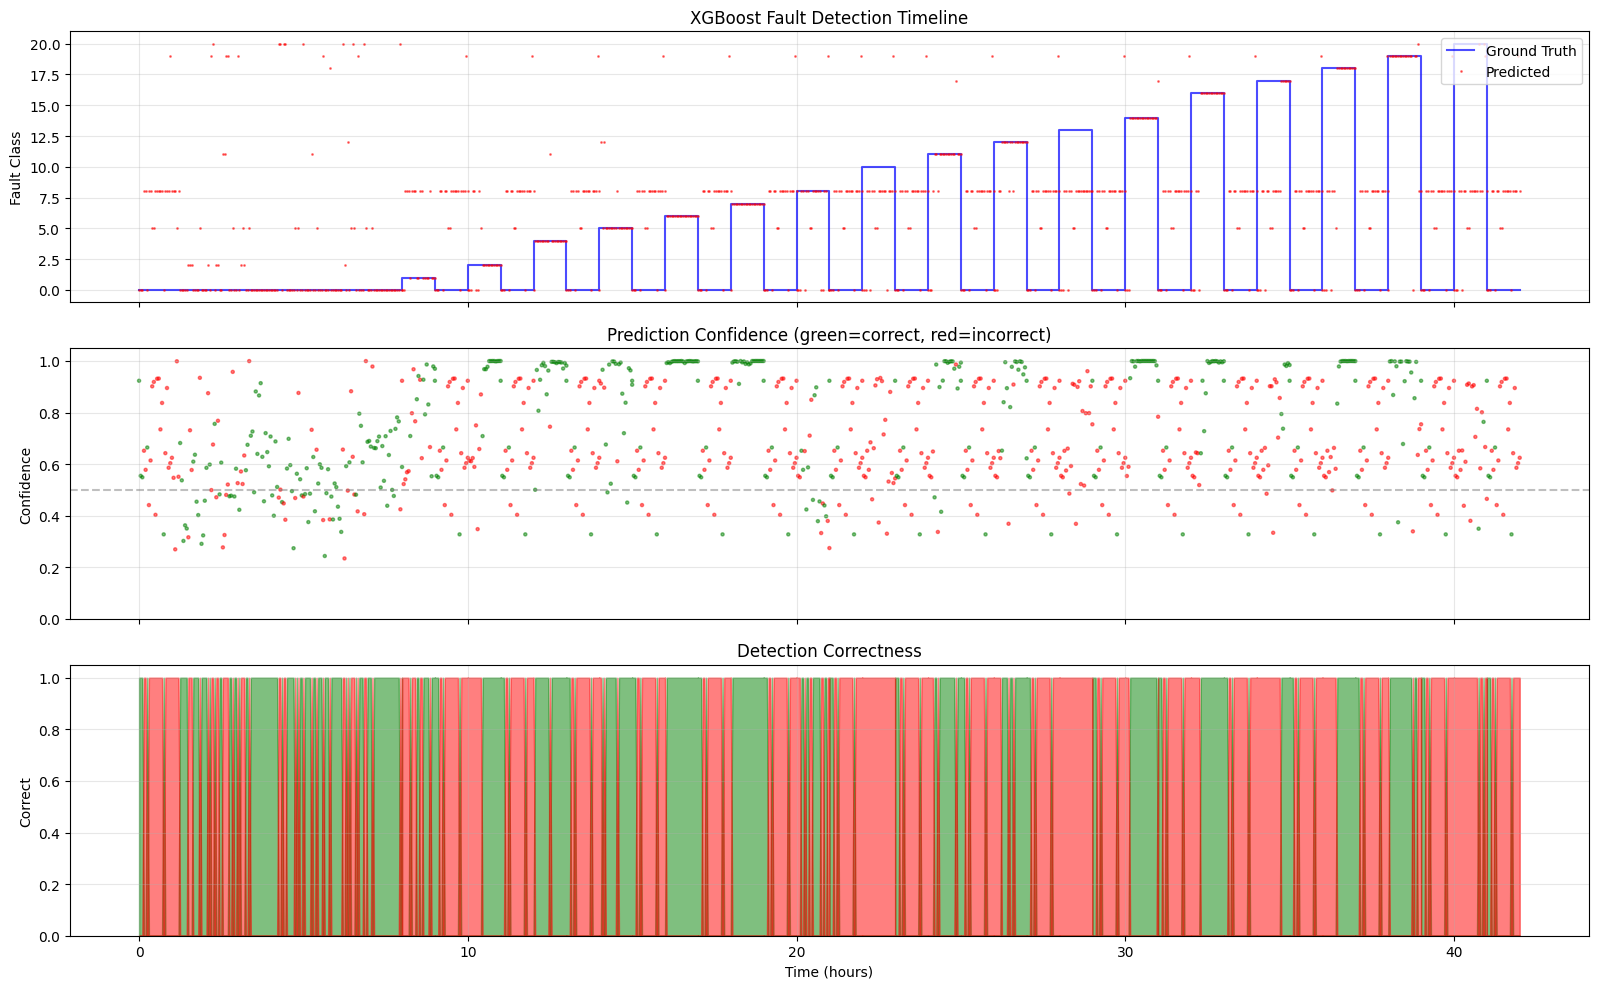

✓ Saved to ../outputs/figures/xgboost_detector_timeline.png


In [9]:
# Detection timeline
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

time_hours = detections_df['time_hours'].values

# Plot 1: Ground truth vs predictions
ax = axes[0]
ax.plot(time_hours, detections_df['true_class'], 'b-', linewidth=1.5, label='Ground Truth', alpha=0.7)
ax.plot(time_hours, detections_df['predicted_class'], 'r.', markersize=2, label='Predicted', alpha=0.5)
ax.set_ylabel('Fault Class')
ax.set_title('XGBoost Fault Detection Timeline')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot 2: Confidence
ax = axes[1]
colors = ['green' if c else 'red' for c in detections_df['correct']]
ax.scatter(time_hours, detections_df['confidence'], c=colors, s=5, alpha=0.5)
ax.set_ylabel('Confidence')
ax.set_ylim(0, 1.05)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Prediction Confidence (green=correct, red=incorrect)')
ax.grid(True, alpha=0.3)

# Plot 3: Correct/Incorrect
ax = axes[2]
ax.fill_between(time_hours, detections_df['correct'].astype(int), alpha=0.5, color='green', label='Correct')
ax.fill_between(time_hours, 1 - detections_df['correct'].astype(int), alpha=0.5, color='red', label='Incorrect')
ax.set_ylabel('Correct')
ax.set_xlabel('Time (hours)')
ax.set_title('Detection Correctness')
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'xgboost_detector_timeline{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

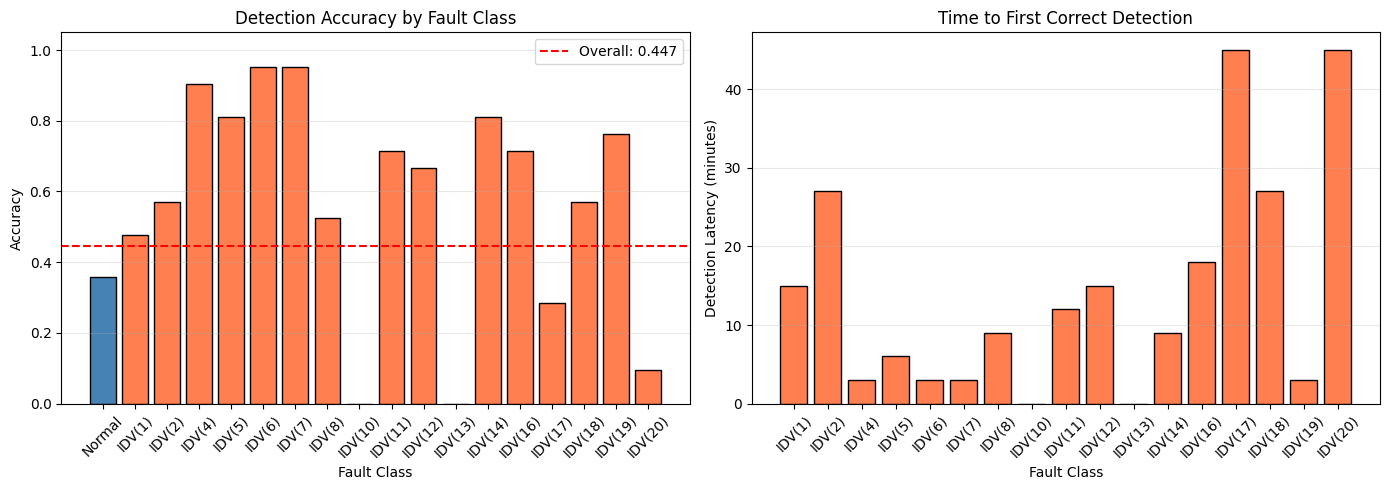

✓ Saved to ../outputs/figures/xgboost_detector_per_fault.png


In [10]:
# Per-fault accuracy bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy by fault
ax = axes[0]
fault_labels = ['Normal' if f == 0 else f'IDV({int(f)})' for f in metrics_df['fault_class']]
colors = ['steelblue' if f == 0 else 'coral' for f in metrics_df['fault_class']]
bars = ax.bar(fault_labels, metrics_df['accuracy'], color=colors, edgecolor='black')
ax.axhline(y=overall_accuracy, color='red', linestyle='--', label=f'Overall: {overall_accuracy:.3f}')
ax.set_xlabel('Fault Class')
ax.set_ylabel('Accuracy')
ax.set_title('Detection Accuracy by Fault Class')
ax.set_ylim(0, 1.05)
ax.legend()
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# Detection latency
ax = axes[1]
fault_only = metrics_df[metrics_df['fault_class'] != 0].copy()
fault_labels_only = [f'IDV({int(f)})' for f in fault_only['fault_class']]
latencies = fault_only['detection_latency_minutes'].fillna(0)
bars = ax.bar(fault_labels_only, latencies, color='coral', edgecolor='black')
ax.set_xlabel('Fault Class')
ax.set_ylabel('Detection Latency (minutes)')
ax.set_title('Time to First Correct Detection')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'xgboost_detector_per_fault{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

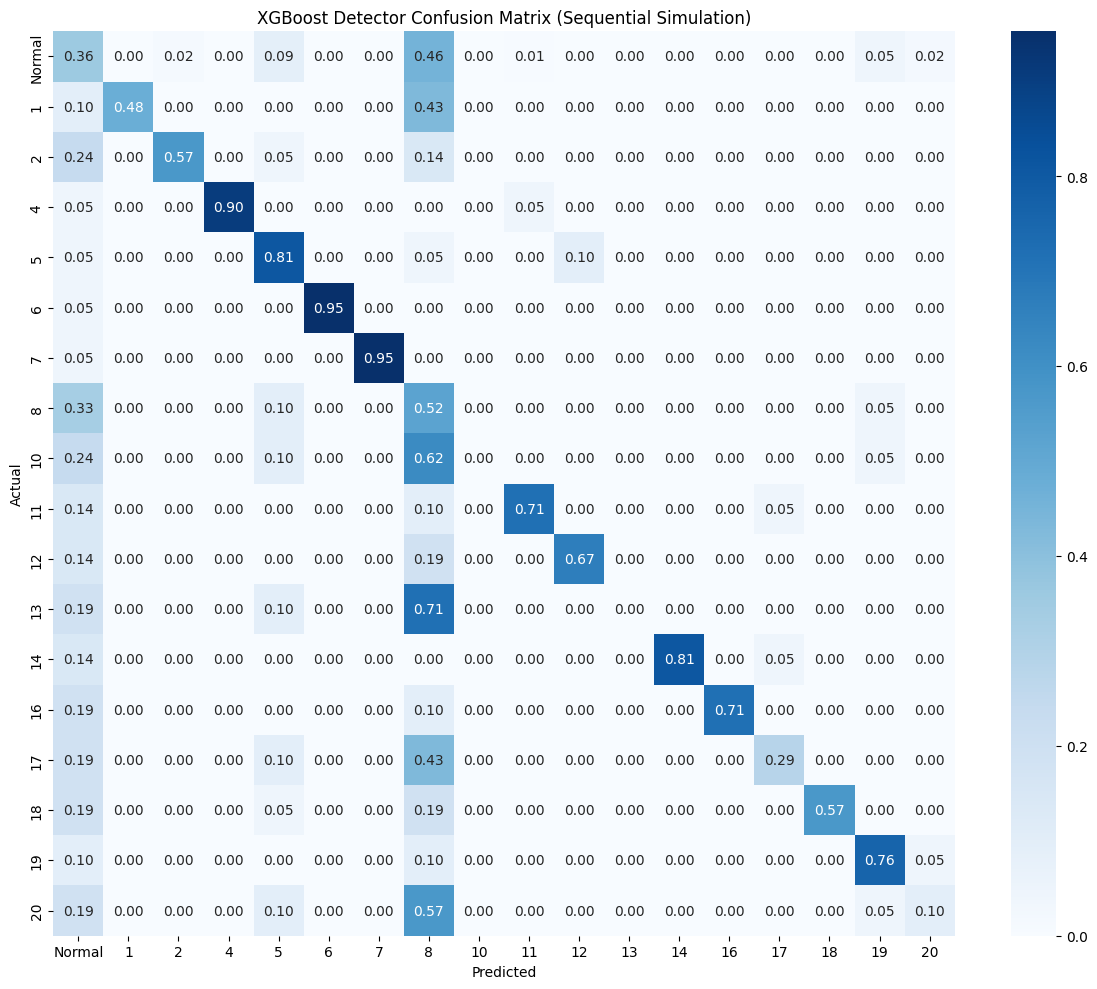

✓ Saved to ../outputs/figures/xgboost_detector_confusion_matrix.png


In [11]:
# Confusion matrix for the sequential simulation
from sklearn.metrics import confusion_matrix

# Get unique classes that appear in the data
all_classes = sorted(set(y_true) | set(y_pred))
class_labels = ['Normal' if c == 0 else str(int(c)) for c in all_classes]

cm = confusion_matrix(y_true, y_pred, labels=all_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBoost Detector Confusion Matrix (Sequential Simulation)')

plt.tight_layout()
output_file = FIGURES_DIR / f'xgboost_detector_confusion_matrix{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

## Save Results

In [12]:
print("\n[Step 5/5] Saving results...")

# Compile results
results = {
    'model': 'XGBoost',
    'detector_type': 'pluggable',
    'quick_mode': QUICK_MODE,
    'simulation': {
        'total_hours': total_duration,
        'total_samples': len(detections_df),
        'normal_hours': NORMAL_HOURS,
        'fault_on_hours': FAULT_ON_HOURS,
        'fault_off_hours': FAULT_OFF_HOURS,
        'faults_tested': FAULT_CLASSES,
        'record_interval_seconds': RECORD_INTERVAL
    },
    'overall_metrics': {
        'accuracy': float(overall_accuracy),
        'balanced_accuracy': float(balanced_acc),
        'f1_weighted': float(f1_weighted),
        'f1_macro': float(f1_macro),
        'fault_detection_accuracy': float(fault_detection_accuracy),
        'fault_detection_precision': float(fault_detection_precision),
        'fault_detection_recall': float(fault_detection_recall)
    },
    'per_fault_metrics': metrics_df.to_dict(orient='records'),
    'average_detection_latency_minutes': float(fault_only['detection_latency_minutes'].mean()) if not fault_only['detection_latency_minutes'].isna().all() else None
}

# Save JSON
output_file = METRICS_DIR / f'xgboost_detector_results{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f"✓ Saved metrics to {output_file}")

# Save detailed detections
detections_file = METRICS_DIR / f'xgboost_detector_detections{FILE_SUFFIX}.csv'
detections_df.to_csv(detections_file, index=False)
print(f"✓ Saved detections to {detections_file}")

# Save per-fault metrics
metrics_file = METRICS_DIR / f'xgboost_detector_per_fault{FILE_SUFFIX}.csv'
metrics_df.to_csv(metrics_file, index=False)
print(f"✓ Saved per-fault metrics to {metrics_file}")


[Step 5/5] Saving results...
✓ Saved metrics to ../outputs/metrics/xgboost_detector_results.json
✓ Saved detections to ../outputs/metrics/xgboost_detector_detections.csv
✓ Saved per-fault metrics to ../outputs/metrics/xgboost_detector_per_fault.csv


In [13]:
print("\n" + "="*60)
print("XGBoost Pluggable Detector Evaluation Complete!")
if QUICK_MODE:
    print("(Quick mode)")
print("="*60)
print(f"\nSimulation: {total_duration} hours, {len(detections_df)} samples")
print(f"Faults tested: {len(FAULT_CLASSES)}")
print(f"\nOverall Performance:")
print(f"  Multiclass Accuracy: {overall_accuracy:.4f}")
print(f"  F1 (weighted): {f1_weighted:.4f}")
print(f"  Fault Detection Recall: {fault_detection_recall:.4f}")
avg_latency = fault_only['detection_latency_minutes'].mean()
if not np.isnan(avg_latency):
    print(f"  Avg Detection Latency: {avg_latency:.1f} minutes")
print("\nOutputs:")
print(f"  - {METRICS_DIR / f'xgboost_detector_results{FILE_SUFFIX}.json'}")
print(f"  - {FIGURES_DIR / f'xgboost_detector_timeline{FILE_SUFFIX}.png'}")
print(f"  - {FIGURES_DIR / f'xgboost_detector_per_fault{FILE_SUFFIX}.png'}")
print(f"  - {FIGURES_DIR / f'xgboost_detector_confusion_matrix{FILE_SUFFIX}.png'}")
print("="*60)


XGBoost Pluggable Detector Evaluation Complete!

Simulation: 42 hours, 875 samples
Faults tested: 17

Overall Performance:
  Multiclass Accuracy: 0.4469
  F1 (weighted): 0.5169
  Fault Detection Recall: 0.8487
  Avg Detection Latency: 16.0 minutes

Outputs:
  - ../outputs/metrics/xgboost_detector_results.json
  - ../outputs/figures/xgboost_detector_timeline.png
  - ../outputs/figures/xgboost_detector_per_fault.png
  - ../outputs/figures/xgboost_detector_confusion_matrix.png
